In [60]:
from qdisk.model import Keplerian_velocity
from qdisk.classes import FitsImage
import eDiskplot as eplot
import analysis_utils as au
from eDisk_source_dict import source_dict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from qdisk.product import calculate_pvdiagram
from astropy.visualization import AsinhStretch
from qdisk.plot import PVDiagram, Map
from matplotlib import ticker
import os
import astropy.constants as ac
import astropy.units as u
import lmfit
from mcmc_tools import EmceeHammer, log_prior, setup_params
from matplotlib.legend_handler import HandlerTuple
%matplotlib widget
%load_ext autoreload
%autoreload 2

cmap = matplotlib.cm.get_cmap("RdBu")
red = cmap(0.12)
blue = cmap(0.88)

source = "L1489IRS"
config = "SBLB"
line = "C18O"
robust = 1.0
dv = 0.2
center_coord = source_dict[source]["radec"]
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
distance = source_dict[source]["distance"]
vsys = source_dict[source]["vsys"]

def arcsec2au(r):
    return r * distance

def au2arcsec(r):
    return r / distance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
imagename = "/works/yamato/eDisk/L1489IRS/custom_images/L1489IRS_SBLB_13CO_robust_1.0_dv0.2.pbcor.fits"
image = FitsImage(imagename)
image.pvcut(PA=PA+180., incl=incl, xrange=(-10, 10), save=True, savefilename="./VADP/" + os.path.basename(imagename).replace(".fits", ".PV_PA{}deg.fits".format(PA)))

Calculating PV diagram...
Done.
Saving PV diagram into ./VADP/L1489IRS_SBLB_13CO_robust_1.0_dv0.2.pbcor.PV_PA67.2deg.fits...


(array([-10.  ,  -9.99,  -9.98, ...,   9.99,  10.  ,  10.01]),
 array([-2.00000006e+00, -1.80000006e+00, -1.60000006e+00, -1.40000006e+00,
        -1.20000006e+00, -1.00000006e+00, -8.00000063e-01, -6.00000063e-01,
        -4.00000063e-01, -2.00000063e-01, -6.31795347e-08,  1.99999937e-01,
         3.99999937e-01,  5.99999937e-01,  7.99999937e-01,  9.99999937e-01,
         1.19999994e+00,  1.39999994e+00,  1.59999994e+00,  1.79999994e+00,
         1.99999994e+00,  2.19999994e+00,  2.39999994e+00,  2.59999994e+00,
         2.79999994e+00,  2.99999994e+00,  3.19999994e+00,  3.39999994e+00,
         3.59999994e+00,  3.79999994e+00,  3.99999994e+00,  4.19999994e+00,
         4.39999994e+00,  4.59999994e+00,  4.79999994e+00,  4.99999994e+00,
         5.19999994e+00,  5.39999994e+00,  5.59999994e+00,  5.79999994e+00,
         5.99999994e+00,  6.19999994e+00,  6.39999994e+00,  6.59999994e+00,
         6.79999994e+00,  6.99999994e+00,  7.19999994e+00,  7.39999994e+00,
         7.59999994e+00, 

Fitting edge...
starting to run the MCMC sampling with: 
 	 initial state: [10.   0.5  7.2] 
 	 number of walkers: 200 
 	 number of steps: 1000


100%|██████████| 1000/1000 [00:05<00:00, 194.88it/s]


Done.
Fitting ridge...
starting to run the MCMC sampling with: 
 	 initial state: [10.   0.5  7.2] 
 	 number of walkers: 200 
 	 number of steps: 1000


100%|██████████| 1000/1000 [00:04<00:00, 208.24it/s]


Done.


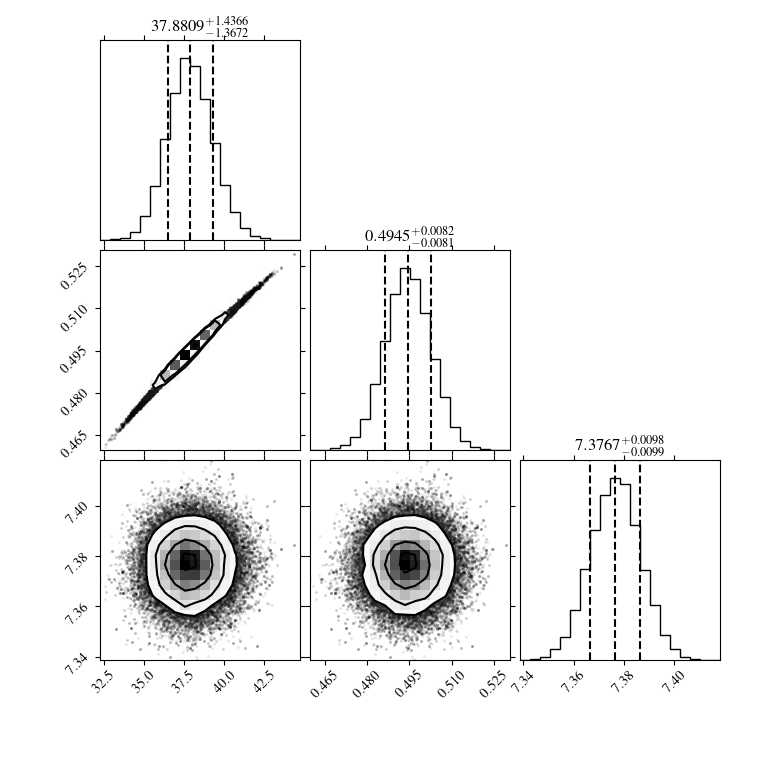

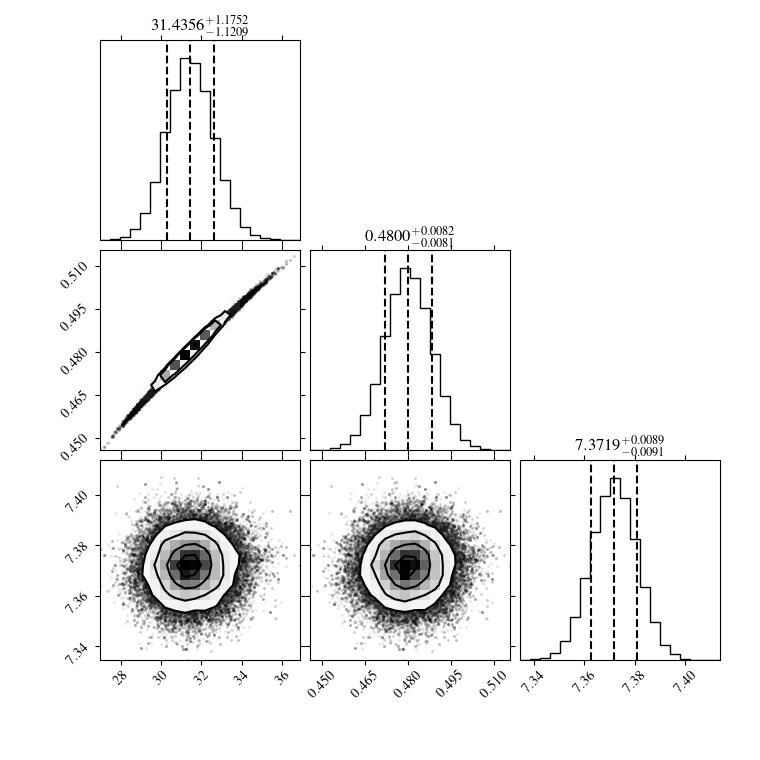

In [72]:
### fit with power-law model
def powerlaw(r, alpha, p, vsys):
    return np.sign(r) * alpha / np.abs(r)**p + vsys

### fit with Keplerian model
def Keplerian_velocity(r, Mstar, vsys):
    vlos = np.sign(r) * np.sqrt(ac.G * Mstar * ac.M_sun / (np.abs(r) * u.au)) * np.sin(np.radians(incl))
    return vlos.to(u.km / u.s).value + vsys

# parameter dictionary
param_dict = {
    "alpha": {"p0": 10, "bound": (0, 1e5), "fixed": False},
    "p": {"p0": 0.5, "bound": (0.3, 0.7), "fixed": False},
    "vsys": {"p0": 7.2, "bound": (6.0, 8.5), "fixed": False},
}
# param_dict = {
#     "Mstar": {"p0": 1.5, "bound": (0.1, 10), "fixed": False},
#     "vsys": {"p0": 7.2, "bound": (6.0, 8.5), "fixed": False},
# }

fitmode = ["edge", "ridge"]
nwalker = 200
nstep = 1000
nburnin = 500

for mode in fitmode:
    # import ridge data
    datafilename_ridge = f"./SLAM/results/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.image_pvDiagram_PA67.2.{mode}.dat"
    x, _, v, dv = np.loadtxt(datafilename_ridge, unpack=True)
    v += vsys

    param_name, fixed_param_name, bound, initial_state = setup_params(param_dict)

    def log_likelihood(param):

        param_dict = {name: p for name, p in zip(param_name, param)}

        # update fixed param
        param_dict.update({name: param_dict[name]["p0"] for name in fixed_param_name})

        # model
        vmodel = powerlaw(x, **param_dict)
        # vmodel = Keplerian_velocity(x, **param_dict)

        # compute log likelihood
        ll = -0.5 * np.sum((v - vmodel)**2 / dv**2 + np.log(2 * np.pi * dv ** 2))

        return ll


    # probability function
    def log_probability(param):
        lp = log_prior(param, bound)
        if not np.isfinite(lp):
            return -np.inf
        ll = log_likelihood(param)
        return lp + ll

    print(f"Fitting {mode}...")
    hammer = EmceeHammer(log_probability=log_probability, initial_state=initial_state, nwalker=nwalker, nstep=nstep)
    hammer.run(save=False, savefilename=f"./fit/L1489IRS_C18O_Keplerian_fit_{mode}.h5")
    hammer.plot_corner(nburnin=nburnin, title_fmt=".4f")
    print("Done.")

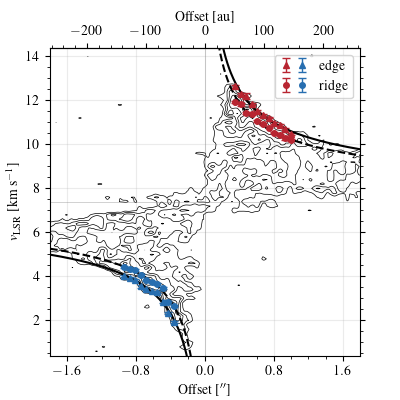

In [ ]:
model = lmfit.Model(Keplerian_velocity)

param_dict = {"Mstar": {"val": 2.0, "range": (0.001, 10), "free": True}, "vsys": {"val": 7.2, "range": (6.0, 8.5), "free": True}}
params = model.make_params()

for param in model.param_names:
    params[param].set(
        value=param_dict[param]["val"],
        min=param_dict[param]["range"][0],
        max=param_dict[param]["range"][1],
        vary=param_dict[param]["free"],
    )

In [7]:
r = 5
line = "SO"
imagename = au.customimagepath + au.get_image_basename(source, config, line, robust=robust, dv=dv)#.replace(".fits", ".specsmooth_width3.fits")
print(imagename)

PA = 85

savefilename = au.VADPpath + au.get_image_basename(source, config, line, robust=robust, dv=dv).replace(".fits", "_pvDiagram_PA{}.fits".format(PA))
posax, velax, diag = calculate_pvdiagram(imagename, center_coord=center_coord, xlim=(-r, r), ylim=(-r, r), PA=PA, rrange=(-r, r), save=True, savefilename=savefilename, overwrite=True)

/raid/work/yamato/edisk_data/L1489IRS/custom_images/L1489IRS_SBLB_SO_robust_1.0_dv0.2.image.fits
Loading data ...
Calculating PV diagram...
Done.
Saving PV diagram into ./VADP/L1489IRS_SBLB_SO_robust_1.0_dv0.2.image_pvDiagram_PA85.fits...


In [8]:
from qdisk.classes import PVFitsImage
from qdisk.plot import PVDiagram

cube = FitsImage(
    au.customimagepath + au.get_image_basename(source, config, "SO", robust=robust)
)
cube.estimate_rms()


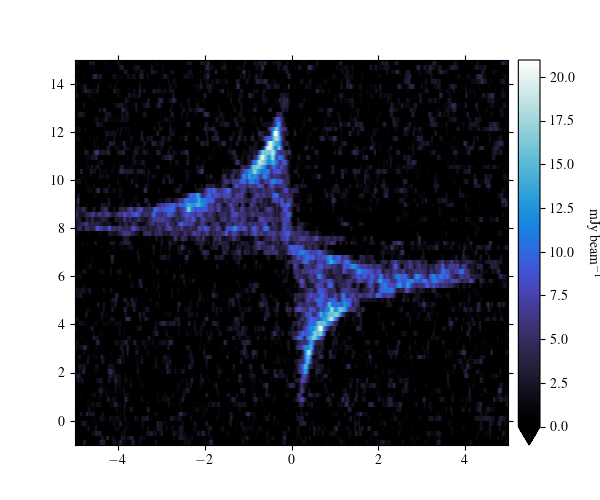

In [9]:
from qdisk.classes import PVFitsImage
from qdisk.plot import PVDiagram 

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=100)

pvfitsname = au.VADPpath + au.get_image_basename(source, config, line, robust=robust).replace(".fits", "_pvDiagram_PA{}.fits".format(PA))
pvdiag = PVDiagram(pvfitsname, ax=ax, data_scaling_factor=1e3)
pvdiag.plot_colormap(cmap=eplot.cmap["M0"], vmin=0.0)#, stretch=AsinhStretch(a=0.1))
pvdiag.add_colorbar(label="mJy beam$^{-1}$", labelpad=20)
# pvdiag.overlay_contour(
#     "./VADP/L1489IRS_SBLB_SO_robust_1.0.image_pvDiagram_PA88.56.fits",
#     data_scaling_factor=1e3,
#     color="tab:orange",
#     levels=np.array([3, 5, 7, 10]) * cube.rms * 1e3,
# )

# ax.set_xlim(-0.5, 0.5)

ax.set_facecolor("black")

# # Keplerian velocity
# vsys = 7.3
# Mstar = 1.403 / np.sin(np.radians(incl))**2
# Mstar_u = 1.416 / np.sin(np.radians(incl))**2
# Mstar_l = 1.390 / np.sin(np.radians(incl))**2
# print(Mstar, Mstar_u, Mstar_l)
# v_red = Keplerian_velocity(r=pvdiag.posax[pvdiag.posax < 0]*distance, Mstar=Mstar, incl=incl) + vsys
# v_blue = - Keplerian_velocity(r=pvdiag.posax[pvdiag.posax > 0]*distance, Mstar=Mstar, incl=incl) + vsys
# v_red_u = Keplerian_velocity(r=pvdiag.posax[pvdiag.posax < 0]*distance, Mstar=Mstar_u, incl=incl) + vsys
# v_blue_u = - Keplerian_velocity(r=pvdiag.posax[pvdiag.posax > 0]*distance, Mstar=Mstar_u, incl=incl) + vsys 
# v_red_l = Keplerian_velocity(r=pvdiag.posax[pvdiag.posax < 0]*distance, Mstar=Mstar_l, incl=incl) + vsys
# v_blue_l = - Keplerian_velocity(r=pvdiag.posax[pvdiag.posax > 0]*distance, Mstar=Mstar_l, incl=incl) + vsys

# ax.plot(pvdiag.posax[pvdiag.posax < 0], v_red, color="white")
# ax.plot(pvdiag.posax[pvdiag.posax > 0], v_blue, color="white")
# ax.fill_between(pvdiag.posax[pvdiag.posax > 0], v_blue_l, v_blue_u, color="white", alpha=0.25)
# ax.fill_between(pvdiag.posax[pvdiag.posax < 0], v_red_l, v_red_u, color="white", alpha=0.25)

# ax.set_ylim(-15, 30)
# ax.set_xlim(-0.4, 0.4)

# ax.set(xlabel="Offset [arcsec]", ylabel="Velocity [km s$^{-1}$]")

# ax.axvline(x=0.0, color="grey", ls="dashed")
# ax.axhline(y=vsys, color="grey", ls="dashed")



In [14]:
fig.savefig(au.figurepath + "C18O_SO_pvDiagram_comparison_zoomed.pdf", bbox_inches="tight", pad_inches=0.01)